In [ ]:
from sklearn.pipeline import Pipeline

clf = Pipeline([
    ('feature_selection', RFE(LogisticRegression(max_iter=2000),4)),
    ('classification', RandomForestClassifier())
])
clf.fit(X, y)

clf.steps

In [5]:
import pickle
with open('../dataset/svm.pkl', 'rb') as f:
        datasets = pickle.load(f)
        print(datasets['features_ganho_informacao'])
        print(datasets['features_ganho_informacao'])            #if 'features_ganho_de_informacao' not in datasets: 
        #    raise ValueError("O dataset não contém 'features_ganho_informacao'. Execute a análise de ganho de informação primeiro.")
        datasets['X_train'] = datasets['X_train'][datasets['features_ganho_informacao']]
        datasets['X_test'] = datasets['X_test'][datasets['features_ganho_informacao']]
        datasets['X_val'] = datasets['X_val'][datasets['features_ganho_informacao']]
        datasets['y_train'] = datasets['y_train']   
        datasets['y_test'] = datasets['y_test']
        datasets['y_val'] = datasets['y_val']
        

['mean_process_net_tx_bytes', 'mean_container_net_tx_packets', 'mean_os_mem_pgfree', 'mean_process_net_rx_bytes', 'mean_container_mem_active_anon', 'mean_os_cpu_interrupts', 'mean_process_disk_read_count', 'mean_os_disk_write_merge', 'mean_os_net_packets_recv', 'mean_os_disk_read_ticks', 'mean_container_cpu_system', 'mean_process_mem_resident', 'mean_os_disk_io_ticks', 'mean_process_disk_read_chars', 'mean_process_cpu_system', 'mean_process_disk_write_count', 'mean_container_mem_inactive_file', 'mean_os_disk_write_io', 'mean_os_mem_pgpgin', 'mean_process_mem_shared', 'mean_container_cpu_user', 'mean_container_net_rx_bytes', 'mean_process_mem_data', 'mean_process_disk_write_bytes', 'mean_os_mem_nr_inactive_file', 'mean_os_cpu_idle', 'mean_os_net_bytes_sent', 'mean_os_disk_time_in_queue', 'mean_os_net_bytes_recv', 'mean_os_cpu_soft_interrupts', 'mean_os_cpu_softirq', 'mean_container_mem_pgpgin', 'mean_os_cpu_user', 'mean_os_cpu_system', 'mean_os_mem_pgfault', 'mean_os_mem_pgpgout', 'mean

In [4]:
import lib_analise  
import pickle

dataset = lib_analise.get_dataset_analise(analise_ganho_de_informacao=True)
print(len(dataset['X_val'].columns.to_list()))
print(len(dataset['X_train'].columns.to_list()))



['mean_process_net_tx_bytes', 'mean_container_net_tx_packets', 'mean_os_mem_pgfree', 'mean_process_net_rx_bytes', 'mean_container_mem_active_anon', 'mean_os_cpu_interrupts', 'mean_process_disk_read_count', 'mean_os_disk_write_merge', 'mean_os_net_packets_recv', 'mean_os_disk_read_ticks', 'mean_container_cpu_system', 'mean_process_mem_resident', 'mean_os_disk_io_ticks', 'mean_process_disk_read_chars', 'mean_process_cpu_system', 'mean_process_disk_write_count', 'mean_container_mem_inactive_file', 'mean_os_disk_write_io', 'mean_os_mem_pgpgin', 'mean_process_mem_shared', 'mean_container_cpu_user', 'mean_container_net_rx_bytes', 'mean_process_mem_data', 'mean_process_disk_write_bytes', 'mean_os_mem_nr_inactive_file', 'mean_os_cpu_idle', 'mean_os_net_bytes_sent', 'mean_os_disk_time_in_queue', 'mean_os_net_bytes_recv', 'mean_os_cpu_soft_interrupts', 'mean_os_cpu_softirq', 'mean_container_mem_pgpgin', 'mean_os_cpu_user', 'mean_os_cpu_system', 'mean_os_mem_pgfault', 'mean_os_mem_pgpgout', 'mean

In [5]:
# (Opcional) instalação — rode no terminal/!pip conforme seu ambiente
# !pip install pandas numpy scikit-learn matplotlib joblib seaborn

import os
from pathlib import Path

# Estrutura de saída
for p in ["reports/figs", "reports/metrics", "models", "data"]:
    Path(p).mkdir(parents=True, exist_ok=True)

print("Estrutura de pastas criada/verificada.")

Estrutura de pastas criada/verificada.


In [9]:
from dataclasses import dataclass, field
from typing import List, Optional, Dict, Any

@dataclass
class StudyConfig:
    random_state: int = 42
    dataset_svm_path: str = "data/svm.csv"
    dataset_terasort_path: str = "data/terasort.csv"
    target_col: str = "target"  # rótulo binário (0/1 ou normal/degradado)
    id_cols: List[str] = field(default_factory=lambda: [])  # ids/timestamps que não entram no X
    drop_cols: List[str] = field(default_factory=lambda: [])  # colunas a remover (vazamento ou irrelevantes)
    positive_label: Optional[Any] = 1  # rótulo considerado "positivo" para ROC/PR; ajuste se necessário
    # Padrões (regex) para dropar colunas suspeitas (vazamento), ex.: elapsed_time, slowdown_ratio, etc.
    drop_patterns_regex: List[str] = field(default_factory=lambda: ['os_timestamp', 'node_name', 'iteration'])
    # Ajustes gerais
    save_png_dpi: int = 150
    run_precision_recall: bool = True
    regression_enabled: bool = False
    regression_target_col: Optional[str] = None  # ex.: "elapsed_time_s", se existir
    # GridSearch
    cv_splits: int = 5
    n_jobs: int = -1

cfg = StudyConfig()
cfg

StudyConfig(random_state=42, dataset_svm_path='data/svm.csv', dataset_terasort_path='data/terasort.csv', target_col='target', id_cols=[], drop_cols=[], positive_label=1, drop_patterns_regex=['os_timestamp', 'node_name', 'iteration'], save_png_dpi=150, run_precision_recall=True, regression_enabled=False, regression_target_col=None, cv_splits=5, n_jobs=-1)

In [10]:
import re
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from typing import Tuple, Dict, Any

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, classification_report,
    confusion_matrix, roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay
)
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.feature_selection import mutual_info_classif
from sklearn.inspection import permutation_importance

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier

from joblib import dump

np.set_printoptions(suppress=True)
pd.set_option("display.max_columns", 200)

In [12]:
def load_and_clean(path: str, target: str, id_cols=None, drop_cols=None, drop_patterns_regex=None) -> pd.DataFrame:
    id_cols = id_cols or []
    drop_cols = drop_cols or []
    drop_patterns_regex = drop_patterns_regex or []

    df = pd.read_csv(path)
    # Padroniza nomes (snake_case rústico)
    df.columns = [re.sub(r'\W+', '_', c).strip('_').lower() for c in df.columns]

    # Encontra colunas a dropar por padrão/regex (possível vazamento)
    to_drop = set(drop_cols)
    for patt in drop_patterns_regex:
        to_drop.update({c for c in df.columns if re.search(patt, c)})

    # Remove id_cols + to_drop, mantendo o target
    cols_keep = [c for c in df.columns if c not in set(id_cols) | to_drop]
    if target not in cols_keep and target in df.columns:
        cols_keep.append(target)
    df = df[cols_keep].copy()

    # Drop NAs simples (ajuste conforme necessidade)
    if df.isna().sum().sum() > 0:
        df = df.dropna().reset_index(drop=True)

    return df

def summarize_df(df: pd.DataFrame, name: str):
    info = {
        "name": name,
        "n_rows": len(df),
        "n_cols": df.shape[1],
        "dtypes": {c: str(t) for c, t in df.dtypes.items()},
        "na_counts": df.isna().sum().to_dict(),
        "target_counts": df[cfg.target_col].value_counts(dropna=False).to_dict() if cfg.target_col in df.columns else {},
    }
    out = Path(f"reports/metrics/df_info_{name}.json")
    out.write_text(json.dumps(info, indent=2, ensure_ascii=False))
    print(f"[OK] DF info salvo em: {out}")
    display(pd.Series(info))
    return info

df_svm = load_and_clean(cfg.dataset_svm_path, cfg.target_col, cfg.id_cols, cfg.drop_cols, cfg.drop_patterns_regex)
df_tera = load_and_clean(cfg.dataset_terasort_path, cfg.target_col, cfg.id_cols, cfg.drop_cols, cfg.drop_patterns_regex)

summarize_df(df_svm, "svm")
summarize_df(df_tera, "terasort")

print("Exemplo (svm.head()):")
display(df_svm.head(3))

[OK] DF info salvo em: reports\metrics\df_info_svm.json


name                                                           svm
n_rows                                                       80648
n_cols                                                         123
dtypes           {'mean_os_cpu_ctx_switches': 'float64', 'mean_...
na_counts        {'mean_os_cpu_ctx_switches': 0, 'mean_os_cpu_g...
target_counts                   {'interf': 45660, 'normal': 34988}
dtype: object

[OK] DF info salvo em: reports\metrics\df_info_terasort.json


name                                                      terasort
n_rows                                                       23246
n_cols                                                         123
dtypes           {'mean_os_cpu_ctx_switches': 'float64', 'mean_...
na_counts        {'mean_os_cpu_ctx_switches': 0, 'mean_os_cpu_g...
target_counts                    {'interf': 16964, 'normal': 6282}
dtype: object

Exemplo (svm.head()):


,mean_os_cpu_ctx_switches,mean_os_cpu_guest,mean_os_cpu_guest_nice,mean_os_cpu_idle,mean_os_cpu_interrupts,mean_os_cpu_iowait,mean_os_cpu_irq,mean_os_cpu_nice,mean_os_cpu_soft_interrupts,mean_os_cpu_softirq,mean_os_cpu_steal,mean_os_cpu_syscalls,mean_os_cpu_system,mean_os_cpu_user,mean_os_disk_discard_io,mean_os_disk_discard_merges,mean_os_disk_discard_sectors,mean_os_disk_discard_ticks,mean_os_disk_in_flight,mean_os_disk_io_ticks,mean_os_disk_read_io,mean_os_disk_read_merge,mean_os_disk_read_sectors,mean_os_disk_read_ticks,mean_os_disk_time_in_queue,mean_os_disk_write_io,mean_os_disk_write_merge,mean_os_disk_write_sectors,mean_os_disk_write_ticks,mean_os_mem_nr_active_anon,mean_os_mem_nr_active_file,mean_os_mem_nr_inactive_anon,mean_os_mem_nr_inactive_file,mean_os_mem_nr_mapped,mean_os_mem_pgfault,mean_os_mem_pgfree,mean_os_mem_pgmajfault,mean_os_mem_pgpgin,mean_os_mem_pgpgout,mean_os_mem_pgreuse,mean_os_net_bytes_recv,mean_os_net_bytes_sent,mean_os_net_dropin,mean_os_net_dropout,mean_os_net_errin,mean_os_net_errout,mean_os_net_num_connections,mean_os_net_packets_recv,mean_os_net_packets_sent,mean_process_cpu_children_system,mean_process_cpu_children_user,mean_process_cpu_iowait,mean_process_cpu_system,mean_process_cpu_user,mean_process_disk_read_bytes,mean_process_disk_read_chars,mean_process_disk_read_count,mean_process_disk_write_bytes,mean_process_disk_write_chars,mean_process_disk_write_count,mean_process_mem_data,mean_process_mem_dt,mean_process_mem_lib,mean_process_mem_resident,mean_process_mem_shared,mean_process_mem_size,mean_process_mem_text,mean_process_net_rx_bytes,mean_process_net_rx_compressed,mean_process_net_rx_drop,mean_process_net_rx_errs,mean_process_net_rx_fifo,mean_process_net_rx_frame,mean_process_net_rx_multicast,mean_process_net_rx_packets,mean_process_net_tx_bytes,mean_process_net_tx_carrier,mean_process_net_tx_colls,mean_process_net_tx_compressed,mean_process_net_tx_drop,mean_process_net_tx_errs,mean_process_net_tx_fifo,mean_process_net_tx_packets,mean_container_cpu_nr_periods,mean_container_cpu_nr_throttled,mean_container_cpu_system,mean_container_cpu_throttled_time,mean_container_cpu_user,mean_container_disk_8_0_async,mean_container_disk_8_0_discard,mean_container_disk_8_0_read,mean_container_disk_8_0_sync,mean_container_disk_8_0_total,mean_container_disk_8_0_write,mean_container_mem_active_anon,mean_container_mem_active_file,mean_container_mem_cache,mean_container_mem_inactive_anon,mean_container_mem_inactive_file,mean_container_mem_mapped_file,mean_container_mem_pgfault,mean_container_mem_pgmajfault,mean_container_mem_pgpgin,mean_container_mem_pgpgout,mean_container_mem_rss,mean_container_mem_unevictable,mean_container_net_rx_bytes,mean_container_net_rx_compressed,mean_container_net_rx_drop,mean_container_net_rx_errs,mean_container_net_rx_fifo,mean_container_net_rx_frame,mean_container_net_rx_multicast,mean_container_net_rx_packets,mean_container_net_tx_bytes,mean_container_net_tx_carrier,mean_container_net_tx_colls,mean_container_net_tx_compressed,mean_container_net_tx_drop,mean_container_net_tx_errs,mean_container_net_tx_fifo,mean_container_net_tx_packets,target
0,22270.0,0.0,0.0,34.31,15074.0,0.0,0.0,0.0,6218.0,0.08,0.0,0.0,2.30,4.36,0.0,0.0,0.0,0.0,0.0,80.0,30.0,0.0,592.0,45.0,61.0,24.0,46.0,944.0,15.0,6.0,6.0,34297.0,-622.0,859.0,133497.0,96295.0,0.0,296.0,472.0,4364.0,1798.0,15909.0,0.0,0.0,0.0,0.0,79.0,20.0,19.0,0.0,0.0,0.0,0.0044,0.0056,0.0,4.442222e+02,6.8889,13198.2222,5965.0,3.1111,0.0,0.0,0.0,1.2222,0.0,0.0,0.0,1841.1111,0.0,0.0,0.0,0.0,0.0,0.0,14.1111,3.606444e+03,0.0,0.0,0.0,0.0,0.0,0.0,16.1111,0.0,0.0,35.0,0.0,77.4,18022.4,0.0,60620.8,60620.8,78643.2,18022.4,4096.0,5734.4,-506265.6,25707315.2,-512000.0,587366.4,24988.8,0.0,22721.6,16564.2,25726976.0,0.0,1786.4,0.0,0.0,0.0,0.0,0.0,0.0,13.2,2346.2,0.0,0.0,0.0,0.0,0.0,0.0,15.8,normal
1,26634.0,0.0,0.0,26.51,22188.0,0.0,0.0,0.0,14863.0,0.98,0.0,0.0,2.50,11.77,0.0,0.0,0.0,0.0,0.0,24.0,4.0,0.0,64.0,2.0,43.0,41.0,75.0,1480.0,41.0,4.0,19.0

In [13]:
def stratified_split_40_30_30(df: pd.DataFrame):
    X = df.drop(columns=[cfg.target_col])
    y = df[cfg.target_col]

    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.60, stratify=y, random_state=cfg.random_state
    )
    X_valid, X_test, y_valid, y_test = train_test_split(
        X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=cfg.random_state
    )

    def _report(lbl, y):
        vc = pd.Series(y).value_counts(normalize=True)
        print(f"{lbl} size={len(y)} | class dist:")
        display(vc.rename("ratio"))

    _report("train", y_train)
    _report("valid", y_valid)
    _report("test", y_test)
    return X_train, y_train, X_valid, y_valid, X_test, y_test

svm_splits = stratified_split_40_30_30(df_svm)
tera_splits = stratified_split_40_30_30(df_tera)

(X_train_svm, y_train_svm, X_valid_svm, y_valid_svm, X_test_svm, y_test_svm) = svm_splits
(X_train_tera, y_train_tera, X_valid_tera, y_valid_tera, X_test_tera, y_test_tera) = tera_splits

train size=32259 | class dist:


target
interf    0.566168
normal    0.433832
Name: ratio, dtype: float64

valid size=24194 | class dist:


target
interf    0.566173
normal    0.433827
Name: ratio, dtype: float64

test size=24195 | class dist:


target
interf    0.56615
normal    0.43385
Name: ratio, dtype: float64

train size=9298 | class dist:


target
interf    0.729727
normal    0.270273
Name: ratio, dtype: float64

valid size=6974 | class dist:


target
interf    0.72971
normal    0.27029
Name: ratio, dtype: float64

test size=6974 | class dist:


target
interf    0.729854
normal    0.270146
Name: ratio, dtype: float64

[OK] MI salvo em: reports\metrics\mi_svm.csv


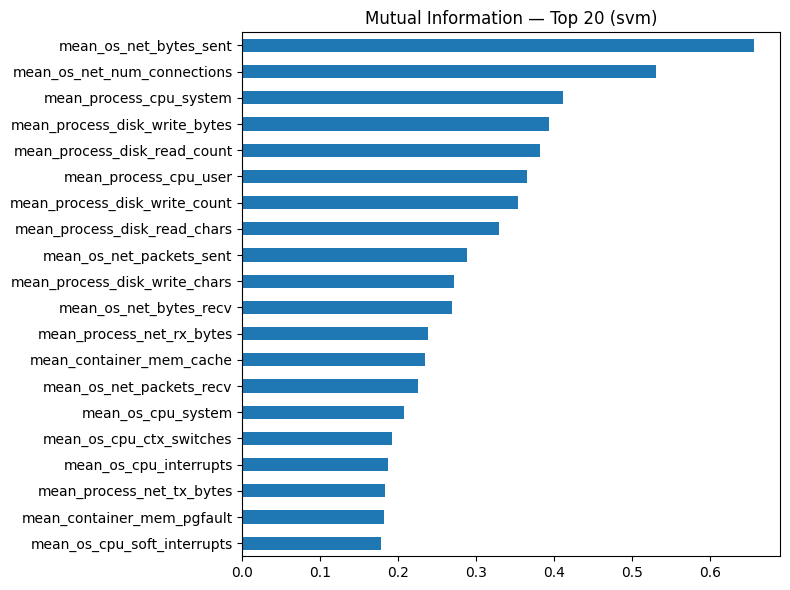

[OK] Figura MI salva em: reports\figs\mi_svm.png
[OK] MI salvo em: reports\metrics\mi_terasort.csv


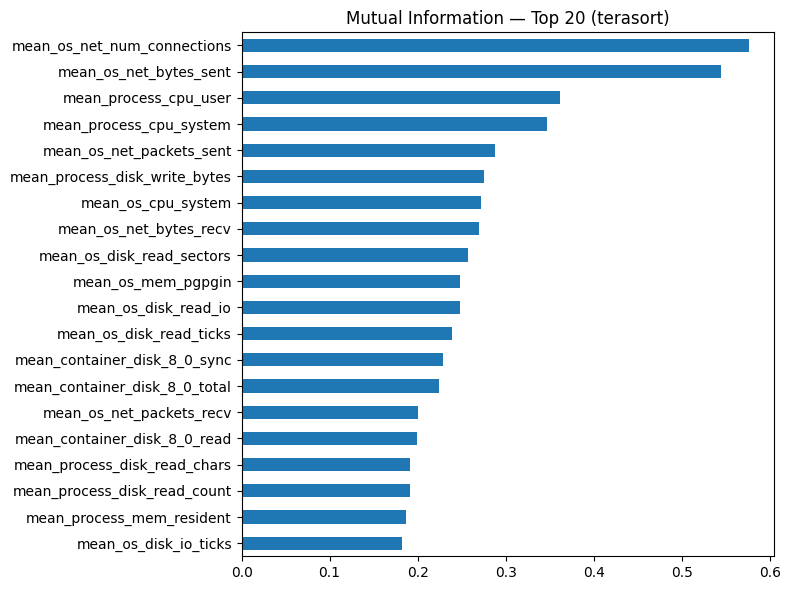

[OK] Figura MI salva em: reports\figs\mi_terasort.png


In [14]:
def compute_mi_and_plot(df: pd.DataFrame, name: str, k_top: int = 20):
    assert cfg.target_col in df.columns, f"Target '{cfg.target_col}' não encontrado em {name}"
    X = df.drop(columns=[cfg.target_col])
    y = df[cfg.target_col]

    # mutual_info_classif não exige padronização; funciona bem com variáveis contínuas e discretas
    mi = mutual_info_classif(X, y, random_state=cfg.random_state)
    mi_s = pd.Series(mi, index=X.columns).sort_values(ascending=False)

    # Salva CSV
    csv_path = Path(f"reports/metrics/mi_{name}.csv")
    mi_s.to_csv(csv_path, header=["mutual_information"])
    print(f"[OK] MI salvo em: {csv_path}")

    # Plot top-k
    top = mi_s.head(k_top)
    plt.figure(figsize=(8, max(3, 0.3*len(top))))
    top.sort_values().plot(kind="barh")
    plt.title(f"Mutual Information — Top {len(top)} ({name})")
    plt.tight_layout()
    fig_path = Path(f"reports/figs/mi_{name}.png")
    plt.savefig(fig_path, dpi=cfg.save_png_dpi)
    plt.show()
    print(f"[OK] Figura MI salva em: {fig_path}")

    return mi_s

mi_svm = compute_mi_and_plot(df_svm, "svm")
mi_tera = compute_mi_and_plot(df_tera, "terasort")

In [15]:
def build_models_and_grids():
    models = {}
    grids = {}

    # Decision Tree
    models["tree"] = DecisionTreeClassifier(random_state=cfg.random_state)
    grids["tree"] = {
        "clf__criterion": ["gini", "entropy"],
        "clf__max_depth": [None, 5, 10, 20]
    }

    # Random Forest
    models["rf"] = RandomForestClassifier(random_state=cfg.random_state, n_estimators=300)
    grids["rf"] = {
        "clf__max_depth": [None, 10, 20],
        "clf__min_samples_split": [2, 5]
    }

    # SVC (com escala)
    models["svc"] = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(probability=True, class_weight="balanced", random_state=cfg.random_state))
    ])
    grids["svc"] = {
        "clf__C": [0.1, 1, 10],
        "clf__kernel": ["rbf", "linear"],
        "clf__gamma": ["scale", "auto"]
    }

    # MLP (com escala)
    models["mlp"] = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", MLPClassifier(max_iter=500, early_stopping=True, random_state=cfg.random_state))
    ])
    grids["mlp"] = {
        "clf__hidden_layer_sizes": [(64,), (128, )],
        "clf__alpha": [1e-4, 1e-3]
    }

    # Dummy (baseline)
    models["dummy"] = DummyClassifier(strategy="most_frequent")
    grids["dummy"] = {}

    return models, grids

models, grids = build_models_and_grids()
list(models.keys())

['tree', 'rf', 'svc', 'mlp', 'dummy']

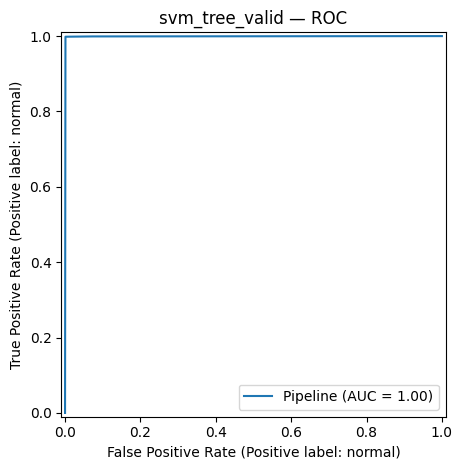

[OK] ROC salvo em: reports\figs\svm_tree_valid_roc.png


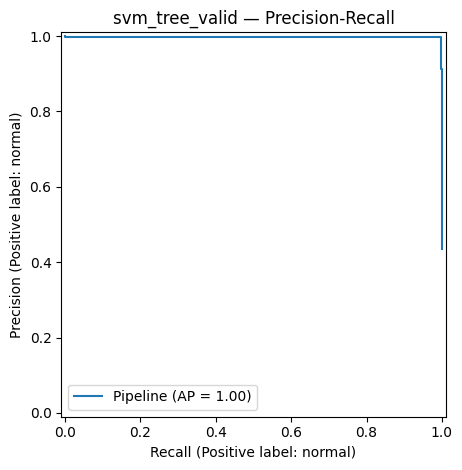

[OK] PR Curve salva em: reports\figs\svm_tree_valid_pr.png


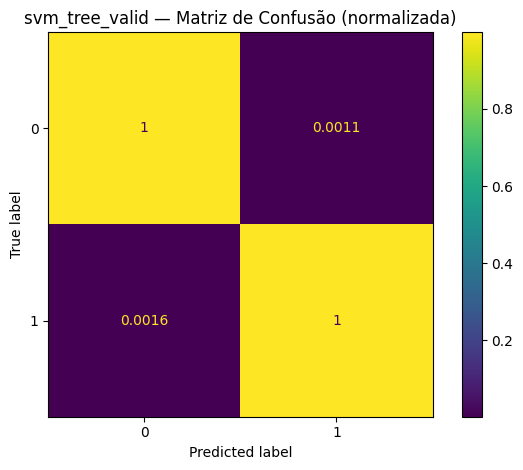

[OK] CM salva em: reports\figs\svm_tree_valid_cm.png
[OK] Modelo salvo em: models\svm_tree.joblib


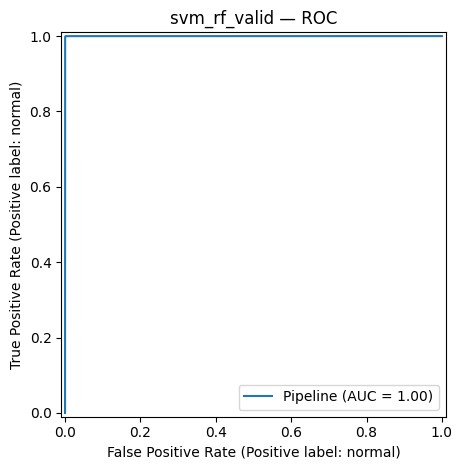

[OK] ROC salvo em: reports\figs\svm_rf_valid_roc.png


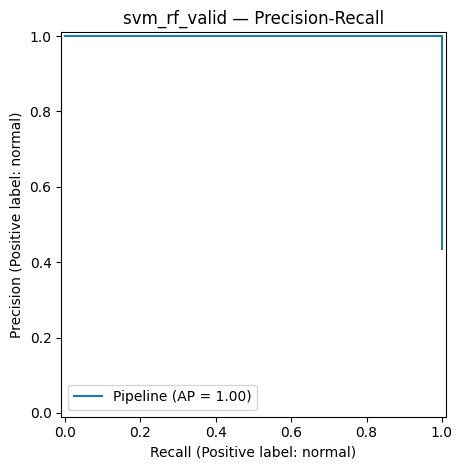

[OK] PR Curve salva em: reports\figs\svm_rf_valid_pr.png


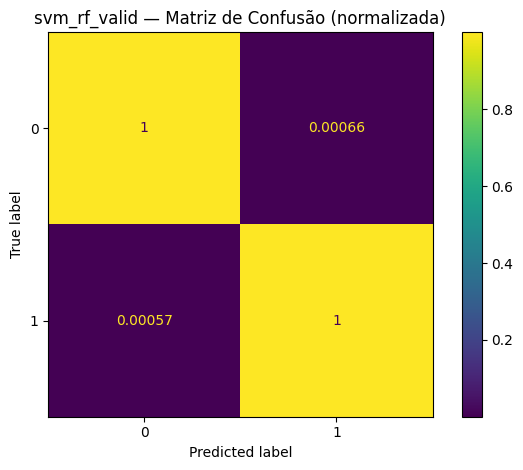

[OK] CM salva em: reports\figs\svm_rf_valid_cm.png
[OK] Modelo salvo em: models\svm_rf.joblib


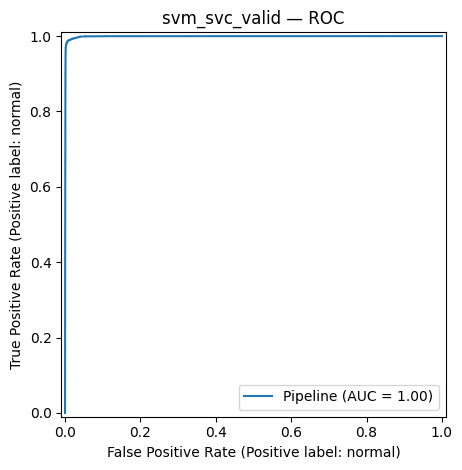

[OK] ROC salvo em: reports\figs\svm_svc_valid_roc.png


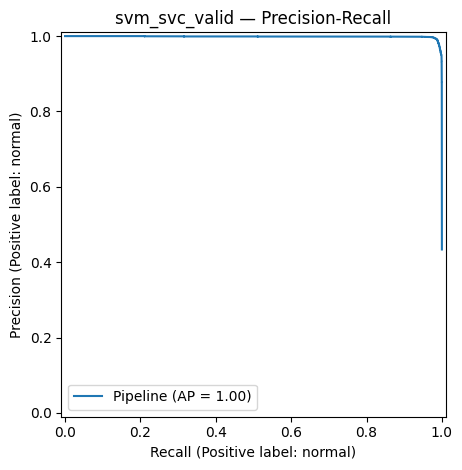

[OK] PR Curve salva em: reports\figs\svm_svc_valid_pr.png


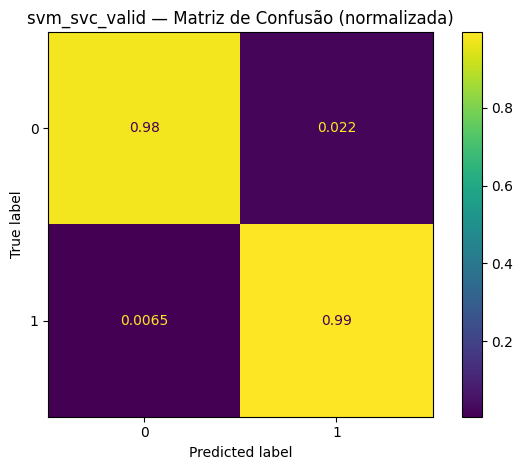

[OK] CM salva em: reports\figs\svm_svc_valid_cm.png
[OK] Modelo salvo em: models\svm_svc.joblib


ValueError: 
All the 20 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\leopi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\leopi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\leopi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py", line 663, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "C:\Users\leopi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\leopi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py", line 849, in fit
    return self._fit(X, y, sample_weight=sample_weight, incremental=False)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\leopi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py", line 508, in _fit
    self._fit_stochastic(
  File "C:\Users\leopi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py", line 748, in _fit_stochastic
    self._update_no_improvement_count(
  File "C:\Users\leopi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py", line 798, in _update_no_improvement_count
    val_score = self._score(X, y, sample_weight=sample_weight)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\leopi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py", line 1289, in _score
    return super()._score_with_function(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\leopi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py", line 864, in _score_with_function
    if np.isnan(y_pred).any() or np.isinf(y_pred).any():
       ^^^^^^^^^^^^^^^^
TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''


In [16]:
def _get_scores(y_true, y_pred, y_score=None) -> Dict[str, Any]:
    out = {
        "accuracy": accuracy_score(y_true, y_pred),
        "balanced_accuracy": balanced_accuracy_score(y_true, y_pred),
    }
    # Classification report (macro F1 e por classe)
    rep = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    out["f1_macro"] = rep.get("macro avg", {}).get("f1-score", np.nan)
    out["precision_macro"] = rep.get("macro avg", {}).get("precision", np.nan)
    out["recall_macro"] = rep.get("macro avg", {}).get("recall", np.nan)
    out["report_dict"] = rep
    # AUC se disponível
    if y_score is not None:
        try:
            out["roc_auc"] = roc_auc_score(y_true, y_score)
        except Exception as e:
            out["roc_auc"] = np.nan
    else:
        out["roc_auc"] = np.nan
    return out

def _plot_and_save_roc(estimator, X, y, name_prefix: str):
    try:
        disp = RocCurveDisplay.from_estimator(estimator, X, y)
        fig_path = Path(f"reports/figs/{name_prefix}_roc.png")
        plt.title(name_prefix + " — ROC")
        plt.tight_layout()
        plt.savefig(fig_path, dpi=cfg.save_png_dpi)
        plt.show()
        print(f"[OK] ROC salvo em: {fig_path}")
    except Exception as e:
        print(f"[WARN] ROC não gerado: {e}")

def _plot_and_save_pr(estimator, X, y, name_prefix: str):
    if not cfg.run_precision_recall:
        return
    try:
        disp = PrecisionRecallDisplay.from_estimator(estimator, X, y)
        fig_path = Path(f"reports/figs/{name_prefix}_pr.png")
        plt.title(name_prefix + " — Precision-Recall")
        plt.tight_layout()
        plt.savefig(fig_path, dpi=cfg.save_png_dpi)
        plt.show()
        print(f"[OK] PR Curve salva em: {fig_path}")
    except Exception as e:
        print(f"[WARN] PR não gerado: {e}")

def _plot_and_save_cm(y_true, y_pred, name_prefix: str):
    try:
        cm = confusion_matrix(y_true, y_pred, normalize='true')
        disp = ConfusionMatrixDisplay(cm)
        disp.plot()
        fig_path = Path(f"reports/figs/{name_prefix}_cm.png")
        plt.title(name_prefix + " — Matriz de Confusão (normalizada)")
        plt.tight_layout()
        plt.savefig(fig_path, dpi=cfg.save_png_dpi)
        plt.show()
        print(f"[OK] CM salva em: {fig_path}")
    except Exception as e:
        print(f"[WARN] CM não gerada: {e}")

def run_model_selection(X_train, y_train, X_valid, y_valid, dataset_name: str):
    cv = StratifiedKFold(n_splits=cfg.cv_splits, shuffle=True, random_state=cfg.random_state)
    results = []
    best_estimators = {}

    for name, model in models.items():
        pipe = model if isinstance(model, Pipeline) else Pipeline([("clf", model)])
        grid = grids.get(name, {})
        gs = GridSearchCV(
            estimator=pipe,
            param_grid=grid,
            scoring="roc_auc",
            cv=cv,
            n_jobs=cfg.n_jobs,
            refit=True
        )
        gs.fit(X_train, y_train)
        est = gs.best_estimator_

        # Validação
        y_pred = est.predict(X_valid)
        y_score = None
        if hasattr(est, "predict_proba"):
            y_score = est.predict_proba(X_valid)[:, 1]
        elif hasattr(est, "decision_function"):
            y_score = est.decision_function(X_valid)

        scores = _get_scores(y_valid, y_pred, y_score)
        row = {"dataset": dataset_name, "model": name, "best_params": gs.best_params_}
        row.update({k: v for k, v in scores.items() if k != "report_dict"})
        results.append(row)

        # Plots e salvamentos
        prefix = f"{dataset_name}_{name}_valid"
        _plot_and_save_roc(est, X_valid, y_valid, prefix)
        _plot_and_save_pr(est, X_valid, y_valid, prefix)
        _plot_and_save_cm(y_valid, y_pred, prefix)

        # Salva modelo
        model_path = Path(f"models/{dataset_name}_{name}.joblib")
        dump(est, model_path)
        print(f"[OK] Modelo salvo em: {model_path}")

        # Salva classification report detalhado
        rep_path = Path(f"reports/metrics/{dataset_name}_{name}_valid_report.json")
        Path(rep_path).write_text(json.dumps(scores["report_dict"], indent=2, ensure_ascii=False))

        best_estimators[name] = est

    # Salva CSV consolidado de métricas de validação
    df_res = pd.DataFrame(results)
    csv_path = Path(f"reports/metrics/{dataset_name}_valid_metrics.csv")
    df_res.to_csv(csv_path, index=False)
    print(f"[OK] Métricas (validação) salvas em: {csv_path}")

    display(df_res.sort_values("roc_auc", ascending=False))
    return best_estimators, df_res

best_svm, svm_valid = run_model_selection(X_train_svm, y_train_svm, X_valid_svm, y_valid_svm, "svm")
best_tera, tera_valid = run_model_selection(X_train_tera, y_train_tera, X_valid_tera, y_valid_tera, "terasort")

In [ ]:
def get_feature_names_from_estimator(estimator, X_cols):
    # Se for Pipeline, recupera os nomes originais (antes do scaler)
    return list(X_cols)

def plot_importances_series(imp_s: pd.Series, title: str, path_prefix: str, k_top=20):
    top = imp_s.sort_values(ascending=False).head(k_top)
    plt.figure(figsize=(8, max(3, 0.3*len(top))))
    top.sort_values().plot(kind="barh")
    plt.title(title)
    plt.tight_layout()
    fig_path = Path(f"reports/figs/{path_prefix}.png")
    plt.savefig(fig_path, dpi=cfg.save_png_dpi)
    plt.show()
    print(f"[OK] Figura salva em: {fig_path}")

def feature_importances_for_tree(estimator, X_train, name_prefix: str):
    # Suporta Pipeline([..., ('clf', TreeLike)])
    clf = estimator.named_steps["clf"] if isinstance(estimator, Pipeline) else estimator
    if not hasattr(clf, "feature_importances_"):
        print("[INFO] Estimador não possui 'feature_importances_', skip MDI.")
        return None
    cols = X_train.columns
    imp = pd.Series(clf.feature_importances_, index=cols)
    csv_path = Path(f"reports/metrics/{name_prefix}_mdi.csv")
    imp.sort_values(ascending=False).to_csv(csv_path, header=["mdi_importance"])
    print(f"[OK] MDI salvo em: {csv_path}")
    plot_importances_series(imp, f"Importâncias (MDI) — {name_prefix}", f"{name_prefix}_mdi")
    return imp

def permutation_importances(estimator, X_valid, y_valid, name_prefix: str):
    try:
        perm = permutation_importance(
            estimator, X_valid, y_valid,
            n_repeats=20, random_state=cfg.random_state, scoring="roc_auc"
        )
        imp = pd.Series(perm.importances_mean, index=X_valid.columns)
        csv_path = Path(f"reports/metrics/{name_prefix}_perm.csv")
        imp.sort_values(ascending=False).to_csv(csv_path, header=["perm_importance"])
        print(f"[OK] Permutation Importance salvo em: {csv_path}")
        plot_importances_series(imp, f"Permutation Importance — {name_prefix}", f"{name_prefix}_perm")
        return imp
    except Exception as e:
        print(f"[WARN] Permutation Importance falhou: {e}")
        return None

# Exemplo: pegar o melhor RF (se existir) e gerar importâncias
if "rf" in best_svm:
    feature_importances_for_tree(best_svm["rf"], X_train_svm, "svm_rf")
    permutation_importances(best_svm["rf"], X_valid_svm, y_valid_svm, "svm_rf")
if "rf" in best_tera:
    feature_importances_for_tree(best_tera["rf"], X_train_tera, "terasort_rf")
    permutation_importances(best_tera["rf"], X_valid_tera, y_valid_tera, "terasort_rf")

In [ ]:
def cross_dataset_transfer(train_df, test_df, model_names=("rf", "svc"), label_train="svm", label_test="terasort"):
    # Splits do dataset de treino
    X_train, y_train, X_valid, y_valid, _, _ = stratified_split_40_30_30(train_df)

    # Junta train+valid para treinar final (opcional)
    X_final = pd.concat([X_train, X_valid], axis=0)
    y_final = pd.concat([y_train, y_valid], axis=0)

    # Dados do outro dataset (teste)
    X_test = test_df.drop(columns=[cfg.target_col])
    y_test = test_df[cfg.target_col]

    ests = {}
    for name in model_names:
        model = models[name]
        pipe = model if isinstance(model, Pipeline) else Pipeline([("clf", model)])
        grid = grids.get(name, {})
        cv = StratifiedKFold(n_splits=cfg.cv_splits, shuffle=True, random_state=cfg.random_state)
        gs = GridSearchCV(pipe, grid, scoring="roc_auc", cv=cv, n_jobs=cfg.n_jobs, refit=True)
        gs.fit(X_train, y_train)
        est = gs.best_estimator_

        # Refit em train+valid para robustez
        est.fit(X_final, y_final)
        ests[name] = est

        # Avaliação no outro dataset
        y_pred = est.predict(X_test)
        if hasattr(est, "predict_proba"):
            y_score = est.predict_proba(X_test)[:, 1]
        elif hasattr(est, "decision_function"):
            y_score = est.decision_function(X_test)
        else:
            y_score = None

        scores = _get_scores(y_test, y_pred, y_score)
        prefix = f"transfer_{label_train}_to_{label_test}_{name}"
        _plot_and_save_roc(est, X_test, y_test, prefix)
        _plot_and_save_pr(est, X_test, y_test, prefix)
        _plot_and_save_cm(y_test, y_pred, prefix)

        # Salva métricas
        out_row = {"from": label_train, "to": label_test, "model": name}
        out_row.update({k: v for k, v in scores.items() if k != "report_dict"})
        df_row = pd.DataFrame([out_row])
        out_csv = Path(f"reports/metrics/{prefix}.csv")
        df_row.to_csv(out_csv, index=False)
        print(f"[OK] Métricas de transferência salvas em: {out_csv}")

    return ests

# Executa transferências
_ = cross_dataset_transfer(df_svm, df_tera, model_names=("rf", "svc"), label_train="svm", label_test="terasort")
_ = cross_dataset_transfer(df_tera, df_svm, model_names=("rf", "svc"), label_train="terasort", label_test="svm")